In [2]:
import numpy as np
import matplotlib.pyplot as plt
import msacorrnet as mcn
from copy import deepcopy
from tqdm import tqdm
import matplotlib.cm as cm
import matplotlib as mpl
from sklearn.cluster import AgglomerativeClustering, KMeans
from matplotlib.cm import get_cmap
import random
from scipy.spatial import distance
import importlib
importlib.reload(mcn)
%matplotlib inline

D:\Documents\PhD\Code\causal-improved\.venv\lib\site-packages\tqdm_joblib\__init__.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


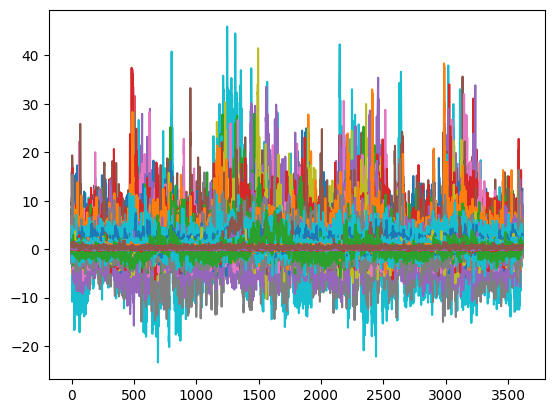

In [3]:
# Loading the data and selecting the gray screen period
data_dir = "../data/SS044/2015-04-28/001/"
dff = np.load(data_dir+'_ss_2pCalcium.dff.npy')
intervals = np.load(data_dir+'_ss_recordings.grayScreen_intervals.npy')[0]
timestamps = np.load(data_dir+'_ss_2pCalcium.timestamps.npy')
running_times = np.load(data_dir+'_ss_running.timestamps.npy')
running_speeds = np.load(data_dir+'_ss_running.speed.npy')
ind_time = np.where((timestamps>intervals[0]) & (timestamps<intervals[1]))[0]
my_activity = dff[ind_time,:]
offset_time = timestamps[ind_time[0]+360]
running_intervals = np.where((running_times>offset_time) & (running_times<intervals[1]))[0]
np.shape(my_activity)
plt.plot(my_activity[:,:])
plt.show()

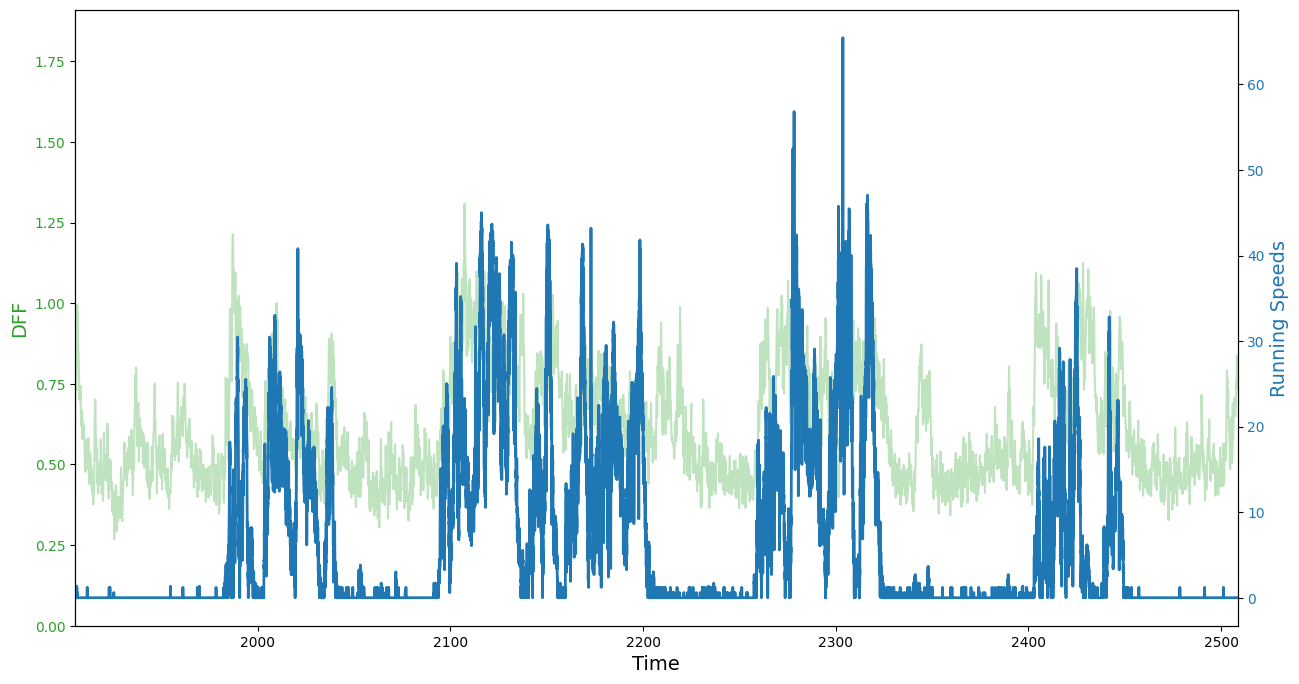

In [4]:
# Create plot of running speed and average neuronal response during gray screen period
fig, ax1 = plt.subplots(figsize=(15, 8))

# Plot the calcium data
color1 = 'tab:green'
ax1.plot(timestamps, np.mean(dff, axis=1), color=color1, alpha=0.3)
ax1.set_xlabel('Time', fontsize=14)
ax1.set_ylabel('DFF', color=color1, fontsize=14)
ax1.tick_params(axis='y', labelcolor=color1)
ax1.set_ylim(min(0, ax1.get_ylim()[0]), max(0, ax1.get_ylim()[1]))

# Secondary axis for the movement plotting
ax2 = ax1.twinx()
color2 = 'tab:blue'
line2, = ax2.plot(running_times, running_speeds, color=color2, label='Running Speeds', linewidth=2)
ax2.set_ylabel('Running Speeds', color=color2, fontsize=14)
ax2.tick_params(axis='y', labelcolor=color2)


# Set x-limits explicitly for both axes
ax1.set_xlim(intervals[0], intervals[-1])
ax2.set_xlim(intervals[0], intervals[-1])

plt.show()

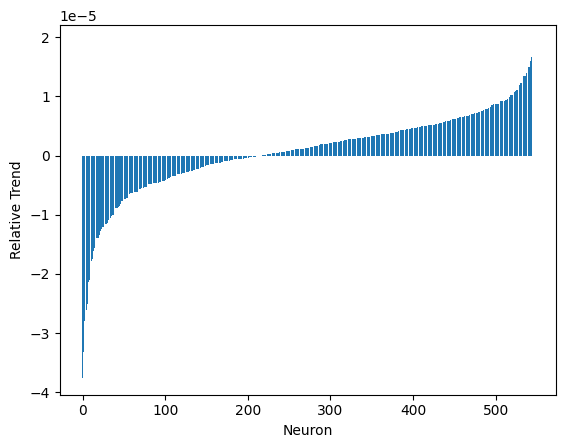

Max positive relative trend: 1.9198893836013033e-05
Max negative relative trend: -4.150331804847941e-08


In [5]:
# Check stationarity assumption holds (generally for all participants it does)
relative_slopes = mcn.check_stationarity(my_activity)
plt.bar(np.arange(relative_slopes.shape[0]), np.sort(relative_slopes))
plt.xlabel("Neuron")
plt.ylabel("Relative Trend")
plt.show()
print(f"Max positive relative trend: {np.max(relative_slopes[np.where(relative_slopes > 0)])}")
print(f"Max negative relative trend: {np.max(relative_slopes[np.where(relative_slopes < 0)])}")

In [6]:
win = 240 # sliding window size, low sizes can make inferences noisy.
step = 5 # how much we move on the window in each time point

r_dict = mcn.rolling_window(my_activity, win, w_shape="tapered", step=step, thr=0.05, type_thr=False, corr="pearsons")

100%|██████████| 675/675 [00:06<00:00, 107.76it/s]


In [7]:
# Need to shift correlations by +1 as cannot take the Laplacian of matrices with negative values
r_pos = {}
for corr in tqdm(r_dict):
    r_pos[corr] = deepcopy(r_dict[corr])
    r_pos[corr] += 1

# Get the eigenspectrum for all matrices
spectra = mcn.all_spectra_parallel(r_pos, True)
all_es = spectra.T
all_es = all_es[:,:-1]

  0%|          | 0/675 [00:00<?, ?it/s]

  0%|          | 0/675 [00:00<?, ?it/s]

In [8]:
# Landmark MDS
landmarks = random.sample(range(0, all_es.shape[0], 1), int(len(all_es) / 4)) # choose random landmarks from 25% of the data
dist = distance.cdist(all_es[landmarks, :], all_es, 'euclidean')
coords = mcn.LMDS(dist, landmarks, 2)

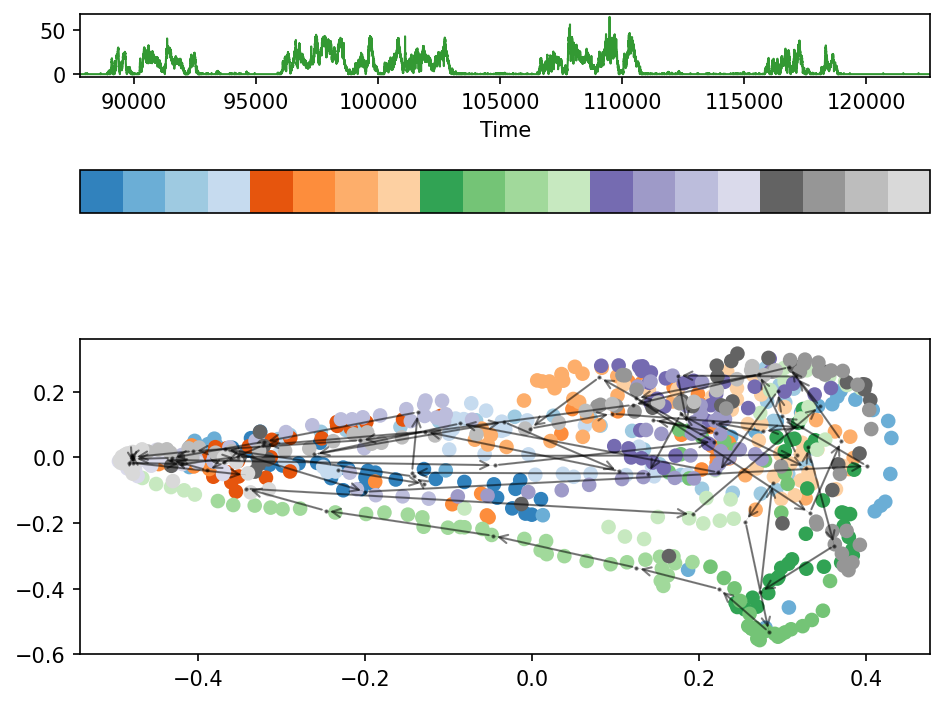

In [19]:
# Plot main figure of A. running speed B. colour bar to match running speed timeseries to scatter C. scatter with colours corresponding to the color bar.
fig, ax = plt.subplot_mosaic('AAA;CCC;BBB', gridspec_kw=dict(
    height_ratios=[1,0.2,5]), dpi=150)


n = len(r_pos)
t = np.arange(0, n)
fin = int(np.floor(len(my_activity)/step)*step)
x_running_speeds = np.arange(running_intervals[0], running_intervals[-1])
cmap_type = "tab20c" # colour map for colour bar and scatter
type_color = "ocean" # colour map for timeseries plot

# Plot running speed timeseries
ax['A'].set_xlabel("Time")
ax['A'].set_xlim((x_running_speeds[0], x_running_speeds[-1]))
ax['A'].plot(x_running_speeds,running_speeds[running_intervals[0]:running_intervals[-1]], alpha=0.8, linewidth=1)
cmap = cm.get_cmap(type_color, np.shape(my_activity)[1])
colors = [cmap(i) for i in range(np.shape(my_activity)[1])]
for i, j in enumerate(ax['A'].lines):
    j.set_color(colors[i])
    
# Plot colour bar to match timeseries and scatter plot
cbar = plt.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(win, my_activity.shape[0]),
                                          cmap=cmap_type),
                    ax=ax['C'],
                    orientation='horizontal',
                    fraction=3.5,
                    pad=0,
)
ax['C'].set_visible(False)
cbar.ax.tick_params(size=0)
cbar.set_ticks([])

# Plot the spectral distance values
ax['B'].scatter(coords[:, 0], coords[:, 1], c=t, cmap=cmap_type, alpha=1)

# Plot average position arrow, n_pts is the number of scatter points to average over
n_pts = 10
if n_pts > 0:
    prev_x = np.mean(coords[0:n_pts, 0])
    prev_y = np.mean(coords[0:n_pts, 1])
    for i in range(10, len(coords), n_pts):
        curr_x = np.mean(coords[i:i+n_pts, 0])
        curr_y = np.mean(coords[i:i+n_pts, 1])
        ax['B'].plot([prev_x, curr_x], [prev_y, curr_y], 'k', alpha=0.5, linewidth=0.1)
        ax['B'].plot(prev_x, prev_y, 'k.', markersize=2, alpha=0.5)
        ax['B'].annotate("",
                              xytext=(prev_x, prev_y),
                              xy=(curr_x, curr_y),
                              arrowprops=dict(arrowstyle="->", color='k', alpha=0.5, linewidth=1))
        prev_x = curr_x
        prev_y = curr_y


plt.tight_layout()
plt.show()

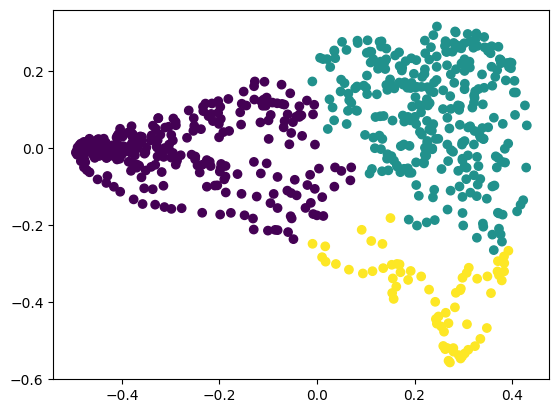

In [24]:
# Clustering
clustering_type = 'Agglomerative'
n_clusters = 3
if clustering_type == "Agglomerative":
    clustering = AgglomerativeClustering(n_clusters=n_clusters, linkage="ward").fit(coords)
    labels=clustering.labels_
else:
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    kmeans.fit(coords)
    labels = kmeans.labels_
    
plt.scatter(coords[:,0], coords[:,1], c=labels, cmap='viridis')

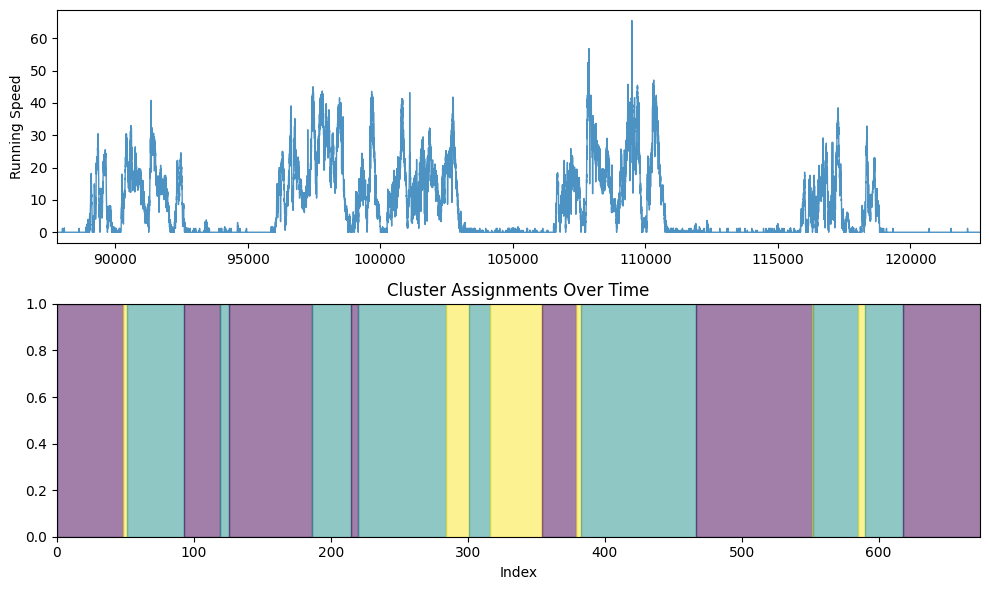

In [28]:
fig, ax = plt.subplots(2, 1, figsize=(10, 6), sharex=False)
indices = range(len(labels))
# Plot the first feature of the original time series data on the first subplot
ax[0].set_xlim((x_running_speeds[0], x_running_speeds[-1]))
ax[0].plot(x_running_speeds,running_speeds[running_intervals[0]:running_intervals[-1]], alpha=0.8, linewidth=1)
ax[0].set_ylabel("Running Speed")

# Generate a color map for the clusters
n_clusters = np.unique(labels).size
cmap = get_cmap('viridis', n_clusters)
colors = {label: cmap(i) for i, label in enumerate(np.unique(labels))}

# Plot cluster time series on the second subplot
prev_label = labels[0]
start_index = indices[0]
for i in range(1, len(labels)):
    if labels[i] != prev_label or i == len(labels) - 1:
        end_index = indices[i] if labels[i] != prev_label else indices[i] + 1
        ax[1].axvspan(start_index, end_index, color=colors[prev_label], alpha=0.5)
        start_index = indices[i]
        prev_label = labels[i]

ax[1].set_title('Cluster Assignments Over Time')
ax[1].set_xlabel('Index')
ax[1].set_xlim(indices[0], indices[-1])

plt.tight_layout()
plt.show()